# Model 2

### Model 2: Binary Classification for Disease Type  

Model 5 (M5) is a binary classification model that distinguishes between two main categories of wheat diseases:  

- **Rust Diseases** 🍂 (Brown Rust, Yellow Rust, Stem Rust, Mildew)  
- **Other Diseases** 🌾 (Fusarium, Loose Smut, Septoria, Common Root Rot)  

This model helps in the initial classification of wheat diseases, directing further analysis to the appropriate specialized model.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [2]:
# Define Dataset Class
class WheatDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load Dataset and Split into Train/Test
def load_data(data_dir, train_split=0.8):
    """
    Load dataset and split into train and test.
    :param data_dir: Path to dataset where folders represent classes.
    :param train_split: Ratio of training data (default: 80% train, 20% test).
    :return: Train and test datasets.
    """
    classes = sorted(os.listdir(data_dir))  # Get class names
    image_paths = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(class_to_idx[cls])

    # Shuffle the dataset
    dataset = list(zip(image_paths, labels))
    random.shuffle(dataset)
    image_paths, labels = zip(*dataset)

    # Split into train and test
    train_size = int(train_split * len(image_paths))
    train_images, test_images = image_paths[:train_size], image_paths[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    return train_images, train_labels, test_images, test_labels, class_to_idx

In [5]:
# Load Data
dataset_path = r"C:\Users\VECTUS\OneDrive\Desktop\Imp\D222"  # Update this with your dataset path
train_images, train_labels, test_images, test_labels, class_to_idx = load_data(dataset_path)

train_dataset = WheatDataset(train_images, train_labels, transform=transform)
test_dataset = WheatDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:

# Feature Extractor (EfficientNet)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        self.efficient_net.classifier = nn.Identity()  # Remove last layer

    def forward(self, x):
        return self.efficient_net(x)

In [7]:
class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        self.W1 = nn.Linear(feature_dim, feature_dim)
        self.W2 = nn.Linear(feature_dim, feature_dim)
        self.omega_x = nn.Parameter(torch.rand(feature_dim))
        self.omega_y = nn.Parameter(torch.rand(feature_dim))
        self.omega_xy = nn.Parameter(torch.rand(feature_dim))

    def forward(self, support, query):
        s = torch.relu(self.W1(support))
        q = torch.relu(self.W2(query))
        similarity = torch.sum(self.omega_x * s + self.omega_y * q + self.omega_xy * (s * q), dim=-1)

        # Ensure output matches EfficientNet feature size (1280)
        output = torch.relu(self.W1(support) + self.W2(query))
        return output  # Output must be (batch_size, 1280)

In [8]:
# Few-Shot Learning Network
class FewShotNetwork(nn.Module):
    def __init__(self, feature_dim=1280, num_classes=4):
        super(FewShotNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.attention = AttentionModule(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, support, query):
        support_features = self.feature_extractor(support)
        query_features = self.feature_extractor(query)
        similarity = self.attention(support_features, query_features)
        output = self.fc(similarity)
        return output


In [9]:
# Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FewShotNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\VECTUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training Loop
def train_model(model, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, images)  # Support and Query Set (same for now)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader)

Epoch [1/20], Loss: 0.2813
Epoch [2/20], Loss: 0.1444
Epoch [3/20], Loss: 0.0913
Epoch [4/20], Loss: 0.0752
Epoch [5/20], Loss: 0.0577
Epoch [6/20], Loss: 0.0550
Epoch [7/20], Loss: 0.0474
Epoch [8/20], Loss: 0.0383
Epoch [9/20], Loss: 0.0300
Epoch [10/20], Loss: 0.0400
Epoch [11/20], Loss: 0.0442
Epoch [12/20], Loss: 0.0298
Epoch [13/20], Loss: 0.0217
Epoch [14/20], Loss: 0.0256
Epoch [15/20], Loss: 0.0263
Epoch [16/20], Loss: 0.0222
Epoch [17/20], Loss: 0.0144
Epoch [18/20], Loss: 0.0256
Epoch [19/20], Loss: 0.0348
Epoch [20/20], Loss: 0.0194


Test Accuracy: 97.17%


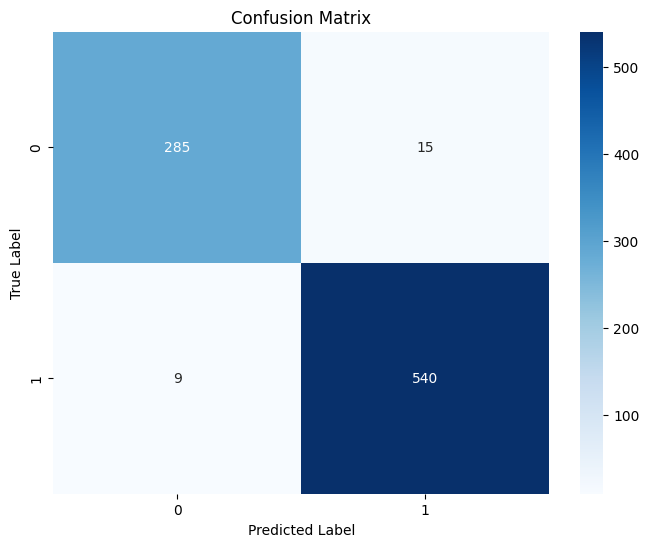

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Pass two inputs if required
            outputs = model(images, images)  # Check if this matches your model's expected inputs
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function
evaluate_model(model, test_loader)

In [13]:
# Save the entire model
torch.save(model.state_dict(), "model2.pth")
print("Model saved successfully!")


Model saved successfully!
